In [35]:
import numpy as np
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt  

### The frequency (or retardance) is a function of wavelength. The data is uneven in wavenumber (the inverse of wavelenght)

In [36]:
t_hor = 5010; #um
lambda_min = 7; #um
lambda_max = 13;
waves = np.linspace(7,12,120)
A_ne = 4.0832;
B_ne = 2.0041;
C_ne = .20646;
D_ne = 3.9928;
E_ne = 3866.92;
A_no = 4.1318;
B_no = 1.8584;
C_no = .21999;
D_no = 2.76773;
E_no = 2962.98;
def retardance(wavelength):
    ne = np.sqrt(A_ne + (B_ne*wavelength**2)/(wavelength**2 - C_ne) + (D_ne*wavelength**2)/(wavelength**2 - E_ne));
    no = np.sqrt(A_no + (B_no*wavelength**2)/(wavelength**2 - C_no) + (D_no*wavelength**2)/(wavelength**2 - E_no)); 
    b = ne - no; 

    retardance = (b*t_hor);
    return retardance

In [37]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [38]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [39]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c)) #cm
wavnums=list(map(lambda l :1/(l*1.0e-4),waves)) #cm
ret=list(map(lambda l :(retardance(l))*1.0e-4,lambda_c)) #cm

### In this first example, I am generating simulated data with a constant frequency (the mean of the retardance)

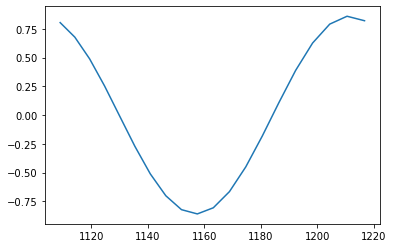

In [40]:
j = 32
start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
retardance = [ret[start:stop][i] for i in range(len(ret[start:stop]))]

f = np.mean(retardance)
t = wavnums[start:stop] 
delta = [2*np.pi*f*t[i] for i in range(len(ret[start:stop]))]
d = np.array(delta)
a = .67  #trying to estimate these coeffs
b = .54
y = a*np.sin(d)+ b*np.cos(d) 
plt.plot(t,y)

In [41]:
frequency, power = LombScargle(t, y).autopower()

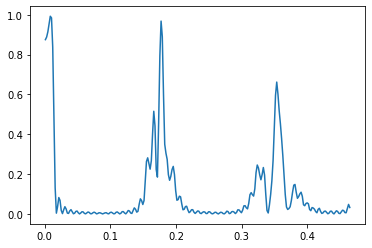

In [42]:
plt.plot(frequency, power)  

In [43]:
frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
...                                                    maximum_frequency=ret[j-9],
...                                                    samples_per_peak=1900)
len(frequency)

32

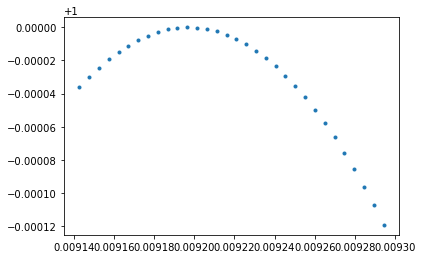

In [44]:
plt.plot(frequency, power,'.')   

In [45]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(wavnums[stop],wavnums[start])
ls = LombScargle(t, y)
y_fit = ls.model(t_fit, best_frequency)

## this first example correctly estimated the frequency and coeffs

In [46]:
f, best_frequency

(0.009197169827741065, 0.009196554237864044)

In [47]:
theta = ls.model_parameters(best_frequency)
theta.round(2)

array([-0.03,  0.67,  0.54])

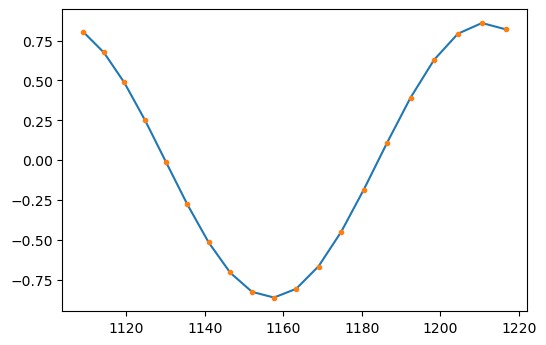

In [48]:
plt.plot(t,theta[1]*np.sin(d)+theta[2]*np.cos(d))
plt.plot(t,y,'.')
#plt.plot(t_fit,y_fit)
plt.gcf().set_dpi(100)

## In this next example, I am still using a constant frequency, but the coefficients are now more complicated: Dcos(2*theta) and Dsin(2*theta))

In [49]:
def model(theta,start,stop,D):
    delta = [2*np.pi*np.mean(ret[start:stop])*wavnums[start:stop][i] for i in range(len(ret[start:stop]))]
    d = np.array(delta)
    return D*np.cos(2*theta)*np.sin(d) + D*np.sin(2*theta)*np.cos(d)

0.009197169827741065
0.009196554237864044
-1.0 -0.0
-1.568539129934313
-1.0 0.0
1.5707963267948966


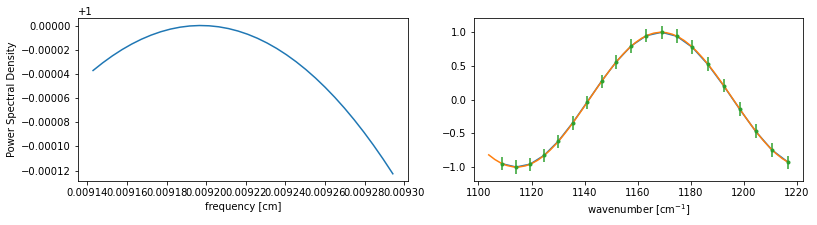

In [50]:
a = 90 #angle of polarization
j = 32 #wavenumber index
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
retardance = [ret[start:stop][i] for i in range(len(ret[start:stop]))]
print(np.mean(retardance))

t = wavnums[start:stop]
D = 1 #degree of polarization

y = model(np.deg2rad(a),start,stop,D)


ls = LombScargle(t, y)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

best_frequency = frequency[np.argmax(power)]
print(best_frequency)
t_fit = np.linspace(wavnums[stop],wavnums[start])
y_fit = ls.model(t_fit, best_frequency)

[offset,q,u] = ls.model_parameters(best_frequency)
print(np.round(q,2),np.round(u,2))
aolp = 0.5*np.arctan2(u,q)
print(aolp)

print(np.round(D*np.cos(2*np.deg2rad(a)),2),np.round(D*np.sin(2*np.deg2rad(a)),2))
print(np.deg2rad(a))

fig, axes = plt.subplots(1,2,figsize=(13, 3)); 
axes[0].plot(frequency, power)
axes[0].set_xlabel('frequency [cm]')
axes[0].set_ylabel('Power Spectral Density')     

dy = .1
plt.plot(t,q*np.sin(d)+u*np.cos(d))
plt.plot(t_fit,y_fit)
axes[1].set_xlabel('wavenumber [cm$^{-1}$]')
axes[1].errorbar(t,y,yerr = dy,fmt='.')
plt.show()

In [51]:
def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    x = wavnums[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(t, y)
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(wavnums[stop],wavnums[start])
    ls = LombScargle(t, y)
    y_fit = ls.model(t_fit, best_frequency)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(best_frequency)
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp,Q,U,prob,np.NAN])

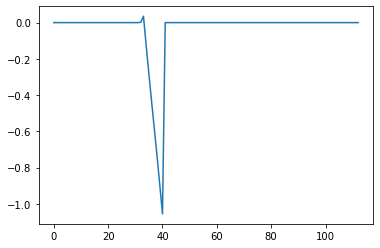

In [52]:
#get offset by finding the retrieved aolp given for an input aolp of zero for each wavelength

offset = []
results = np.zeros([len(lambda_c),360,6]) 
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,.1)  
        except:
            w =1  
            
phase = results[:,0,1]
plt.plot(phase)

In [53]:
def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    t = wavnums[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(t, y)
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(wavnums[stop],wavnums[start])
    ls = LombScargle(t, y)
    y_fit = ls.model(t_fit, best_frequency)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(best_frequency)
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp = aolp - phase[j]
        if dolp > 3:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q] =[np.NAN,np.NAN,np.NAN]
    
    return([Q,U,prob])

In [54]:
angles = np.arange(0,360,1)

#Q and U are the two coefficents

Q1 = np.zeros([len(lambda_c),len(angles[:])]) # D*cos(2theta)
U1 = np.zeros([len(lambda_c),len(angles[:])]) # Dsin(2theta)

for j in range(len(lambda_c)):
    for a in range(360):
        try:
            out = LombModel(a,j,.1)  

            Q1[j,a] = out[0]
            U1[j,a] = out[1]
            
        except:
            pass

In [55]:
## here i am calculating the expected Q and U for a given angle of polarization
D = 1
Q_ex = []
U_ex = []
for i in range(360):
    Q_ex.append(D*np.cos(2*np.deg2rad(i)))
    U_ex.append(D*np.sin((2*np.deg2rad(i))))

## In this example (at one wavelength), the LSP algorithm correctly estimated the coefficients

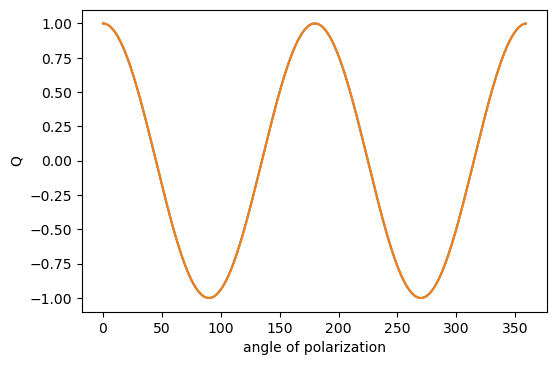

In [56]:
plt.plot(angles[:],Q1[32,:],label='Q retrieved')
plt.plot(angles[:],Q_ex[:],label='Q expected')
plt.ylabel('Q')
plt.xlabel('angle of polarization')
plt.gcf().set_dpi(100)

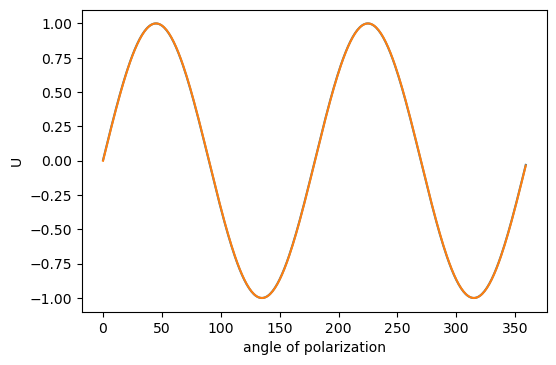

In [57]:
plt.plot(angles[:],U1[32,:],label='U retrieved')
plt.plot(angles[:],U_ex[:],label='U expected')
plt.ylabel('U')
plt.xlabel('angle of polarization')
plt.gcf().set_dpi(100)

## In this final example (which I need assistance on), I am using a non-constant frequency that depends on the wavelength

In [60]:
def model(theta,start,stop,D):
    delta = [2*np.pi*ret[start:stop][i]*wavnums[start:stop][i] for i in range(len(ret[start:stop]))]
    d = np.array(delta)
    return D*np.cos(2*theta)*np.sin(d) + D*np.sin(2*theta)*np.cos(d)

0.009294265450881106
-0.78 0.61
1.2383718856580508
-1.0 0.0
1.5707963267948966


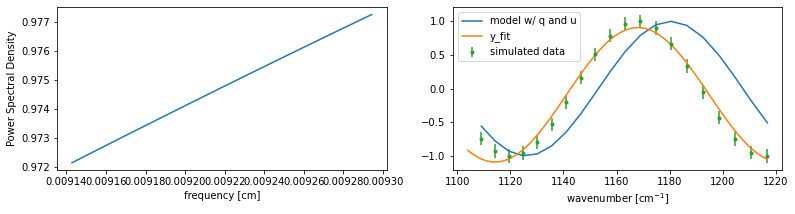

In [82]:
a = 90 #angle of polarization
j = 32 #wavenumber index
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;
retardance = [ret[start:stop][i] for i in range(len(ret[start:stop]))]

t = wavnums[start:stop]
D = 1 #degree of polarization

y = model(np.deg2rad(a),start,stop,D)


ls = LombScargle(t, y)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

best_frequency = frequency[np.argmax(power)]
print(best_frequency)
t_fit = np.linspace(wavnums[stop],wavnums[start])
y_fit = ls.model(t_fit, best_frequency)

[offset,q,u] = ls.model_parameters(best_frequency)
print(np.round(q,2),np.round(u,2))
aolp = 0.5*np.arctan2(u,q)
print(aolp)

print(np.round(D*np.cos(2*np.deg2rad(a)),2),np.round(D*np.sin(2*np.deg2rad(a)),2))
print(np.deg2rad(a))

fig, axes = plt.subplots(1,2,figsize=(13, 3)); 
axes[0].plot(frequency, power)
axes[0].set_xlabel('frequency [cm]')
axes[0].set_ylabel('Power Spectral Density')     

dy = .1
plt.plot(t,q*np.sin(d)+u*np.cos(d),label='model w/ q and u')
plt.plot(t_fit,y_fit,label='y_fit')
axes[1].set_xlabel('wavenumber [cm$^{-1}$]')
axes[1].errorbar(t,y,yerr = dy,fmt='.',label='simulated data')
axes[1].legend()
plt.show()

## above, the y_fit is correct, but when I recreate the model with the estimated coefficients (Q and U), it does not match the fit 

In [64]:
def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    x = wavnums[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(t, y)
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(wavnums[stop],wavnums[start])
    ls = LombScargle(t, y)
    y_fit = ls.model(t_fit, best_frequency)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(best_frequency)
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        if dolp > 1:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp,Q,U,prob,np.NAN])

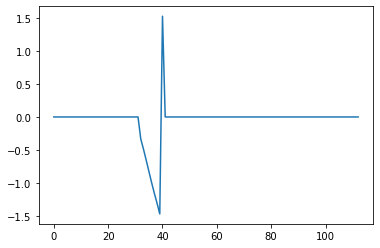

In [65]:
#get offset by finding the retrieved aolp given for an input aolp of zero for each wavelength

offset = []
results = np.zeros([len(lambda_c),360,6]) 
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,.1)  
        except:
            w =1  
            
phase = results[:,0,1]
plt.plot(phase)

In [66]:
def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
 
    t = wavnums[start:stop] 
    y = model(np.deg2rad(a),start,stop,1)

    ls = LombScargle(t, y)
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=ret[j+15],
                                                    maximum_frequency=ret[j-9],
                                                    samples_per_peak=1900)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(wavnums[stop],wavnums[start])
    ls = LombScargle(t, y)
    y_fit = ls.model(t_fit, best_frequency)
    
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,q,u] = ls.model_parameters(best_frequency)
        U = u
        Q = q
        dolp = (((U)**2 +(Q)**2)**0.5)
        aolp = 0.5*np.arctan2(U,Q)
        aolp = aolp - phase[j]
        if dolp > 3:
            [prob,U,Q] =[np.NAN,np.NAN,np.NAN]

    else:
        [prob,U,Q] =[np.NAN,np.NAN,np.NAN]
    
    return([Q,U,prob])

In [67]:
angles = np.arange(0,360,1)

#Q and U are the two coefficents

Q1 = np.zeros([len(lambda_c),len(angles[:])]) # D*cos(2theta)
U1 = np.zeros([len(lambda_c),len(angles[:])]) # Dsin(2theta)

for j in range(len(lambda_c)):
    for a in range(360):
        try:
            out = LombModel(a,j,.1)  

            Q1[j,a] = out[0]
            U1[j,a] = out[1]
            
        except:
            pass

In [68]:
## here i am calculating the expected Q and U for a given angle of polarization
D = 1
Q_ex = []
U_ex = []
for i in range(360):
    Q_ex.append(D*np.cos(2*np.deg2rad(i)))
    U_ex.append(D*np.sin((2*np.deg2rad(i))))

## As a result, the coefficients are shifted and not correctly estimated as they were in the case of the constant frequency

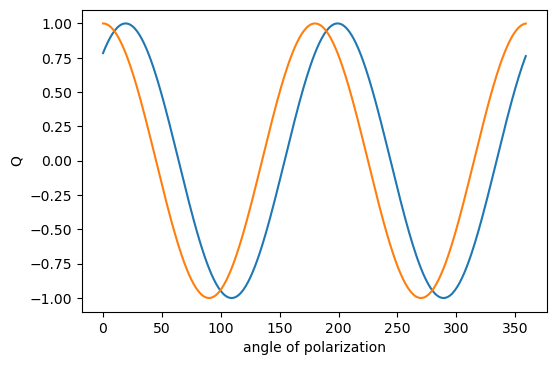

In [69]:
plt.plot(angles[:],Q1[32,:],label='Q retrieved')
plt.plot(angles[:],Q_ex[:],label='Q expected')
plt.ylabel('Q')
plt.xlabel('angle of polarization')
plt.gcf().set_dpi(100)

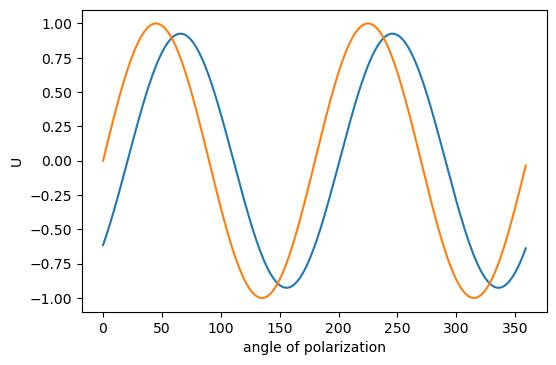

In [70]:
plt.plot(angles[:],U1[32,:],label='U retrieved')
plt.plot(angles[:],U_ex[:],label='U expected')
plt.ylabel('U')
plt.xlabel('angle of polarization')
plt.gcf().set_dpi(100)